# a gentle exploration tour through the Monad-Bayes library

https://github.com/adscib/monad-bayes

In [110]:
:e OverloadedStrings

import qualified Graphics.Vega.VegaLite as VL
import Graphics.Vega.VegaLite hiding (filter)
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL

import Control.Monad (liftM2, replicateM)
import Control.Monad.IO.Class (liftIO)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Inference.SMC


import Numeric.Log
import Control.Monad.Bayes.Class


barPlot :: [Int] -> VegaLite
barPlot dataSamples = 
  let desc = description "Probability Games"
      dat = dataFromColumns []
          . dataColumn "Result" (Numbers (map fromIntegral dataSamples))
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (BarStyle [ MContinuousBandSize 20 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      barOpts = [MOpacity 0.4, MColor "blue"]
      enc = encoding
            . position X [PName "Result", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PAggregate Count, PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], conf [], mark Bar barOpts, enc []]
  
linePlot :: [Double] -> [Double] -> VegaLite
linePlot xSamples ySamples = 
  let desc = description "Logistic Regression"
      dat = dataFromColumns []
          . dataColumn "X" (Numbers xSamples)
          . dataColumn "Y" (Numbers ySamples)
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      enc = encoding
            . position X [PName "X", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PName "Y", PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], conf [], mark Line [], enc []]

pointPlot :: [Double] -> [Double] -> VegaLite
pointPlot xSamples ySamples = 
  let desc = description "Logistic Regression"
      dat = dataFromColumns []
          . dataColumn "X" (Numbers xSamples)
          . dataColumn "Y" (Numbers ySamples)
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      enc = encoding
            . position X [PName "X", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PName "Y", PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], conf [], mark Point [MOpacity 0.2], enc []]

## Modelling Dice

In [85]:
-- A toy model for dice rolling from http://dl.acm.org/citation.cfm?id=2804317
-- Exact results can be obtained using Dist monad

-- | A toss of a six-sided die.
die :: MonadSample m => m Int
die = uniformD [1..6]

-- | A sum of outcomes of n independent tosses of six-sided dice.
dice :: MonadSample m => Int -> m Int
dice 1 = die
dice n = liftM2 (+) die (dice (n-1))

-- | Toss of two dice where the output is greater than 4.
dice_hard :: MonadInfer m => m Int
dice_hard = do
  result <- dice 2
  condition (result > 4)
  return result

In [86]:
takeFromModel :: Int -> Sequential (Population SamplerIO) a -> IO [a]
takeFromModel nsamples inModel = sampleIOfixed $ do
    res <- runPopulation $ smcMultinomial 0 nsamples inModel
    return $ map fst res

In [87]:
takeFromModel 20 dice_hard

[3,7,10,6,7,9,5,7,6,8,11,11,4,7,10,11,8,8,6,7]

## Two alternating distributions

In [51]:
prior :: MonadSample m => m Double
prior = return 0.2

modelFalse :: MonadSample m => m Int
modelFalse = uniformD ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] :: [Int])

modelTrue :: MonadSample m => m Int
modelTrue = do
  x <- bernoulli 0.5
  y <- uniformD (if x then [1, 2] else [11, 12] :: [Int])
  return y

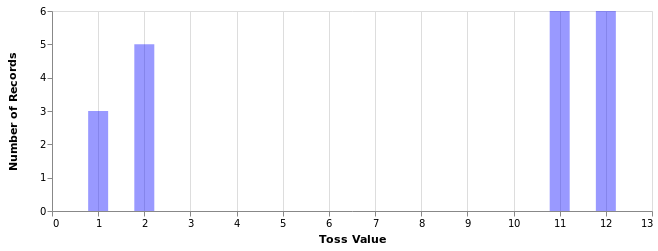

In [54]:
samples <- sampleToList 20 modelTrue
vlShow $ barPlot samples

## Logistic Regression

In [43]:
xs = fromInteger <$> [-10, -5, 2, 6, 10]
labels = fromIntegral <$> fromEnum <$> [False, False, True, True, True]

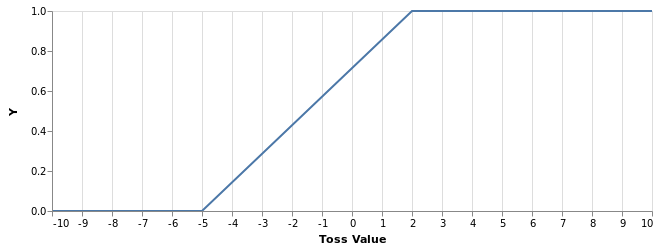

In [89]:
vlShow $ linePlot xs labels

both normal and gamma are functions that take two parameters and that return distributions with the _MonadSample_ interface:

In [62]:
:t normal
:t gamma

normal :: forall (m :: * -> *). MonadSample m => Double -> Double -> m Double

gamma :: forall (m :: * -> *). MonadSample m => Double -> Double -> m Double

we now build a sigmoid function from those. First we build a scaled and shifted normal distribution that is then passed through the exponential.

In [90]:
sigmoid :: MonadSample m => Double -> m Double
sigmoid x = do
    m <- normal 0 1
    b <- normal 0 1
    sigma <- gamma 1 1
    n <- normal (m * x + b) sigma
    return (1 / (1 + exp (- n)))

we can take 100 samples of the final distribution at a few x values and plot the resulting model distribution ...

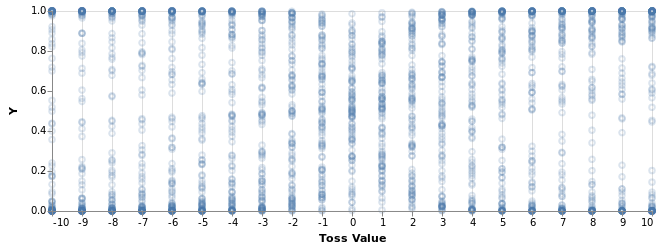

In [115]:
nsamples = 100
xValues = [-10..10]
yValues <- sequence (takeFromModel nsamples <$> (sigmoid <$> xValues))
vlShow $ pointPlot (xValues >>= replicate nsamples) (mconcat yValues)

the sigmoidal structure of the distribution becomes quite clear. The goal of the inference algorithm will be to find parameters that correspond to the observed values.

In [84]:
logisticRegression :: (MonadInfer m) => [(Double, Bool)] -> m Double
logisticRegression dat = do
  let obs x label = do
      p <- sigmoid x
      factor $ (Exp . log) $ if label then p else 1 - p
  mapM_ (uncurry obs) dat
  sigmoid 8

syntheticData :: MonadSample m => Int -> m [(Double, Bool)]
syntheticData n = replicateM n syntheticPoint where
    syntheticPoint = do
      x <- uniform (-1) 1
      label <- bernoulli 0.5
      return (x,label)